# 1. İlgili Kütüpkanalerin yüklenmesi

In [1]:
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

In [2]:
print(tf.__version__)

2.13.0


# 2. Verilerin yüklenmesi

In [3]:
# Verileri bilgisayarımdan yüklüyorum. Verileri bu adresten indirebilirsiniz.
# Adres -> https://www.kaggle.com/datasets/puneet6060/intel-image-classification
train_dir = pathlib.Path("C:\\Users\\Dell\Desktop\\Intel Image Classification\\seg_train\\seg_train")
test_dir = pathlib.Path("C:\\Users\\Dell\\Desktop\\Intel Image Classification\\seg_test\\seg_test")

In [4]:
# eğitim verisindeki toplam resim sayısı
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

14034


In [5]:
# test verisindeki toplam resim sayısı
image_count = len(list(test_dir.glob('*/*.jpg')))
print(image_count)

3000


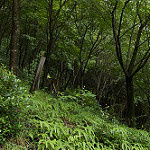

In [6]:
# Eğitim dosyasındaki forest sınıfından örnek bir resim
forest = list(train_dir.glob('forest/*'))
PIL.Image.open(str(forest[0]))

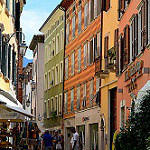

In [7]:
# Test dosyasındaki street sınıfından örnek bir resim
street = list(test_dir.glob('street/*'))
PIL.Image.open(str(street[0]))

In [8]:
# veri kümesini oluşturuyoruz, paket boyutunu 32 olarak resim gelişlik ve yükseklik boyutunu orjinal boyutunu korumak için 150
# olarak aldım.
batch_size = 32
img_height = 150
img_width = 150
train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      seed=120,
      image_size=(img_height, img_width),
      batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(
      test_dir,
      seed=120,
      image_size=(img_height, img_width),
      batch_size=batch_size)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [9]:
# veri setindeki sınıf isimleri
class_names = train_ds.class_names
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


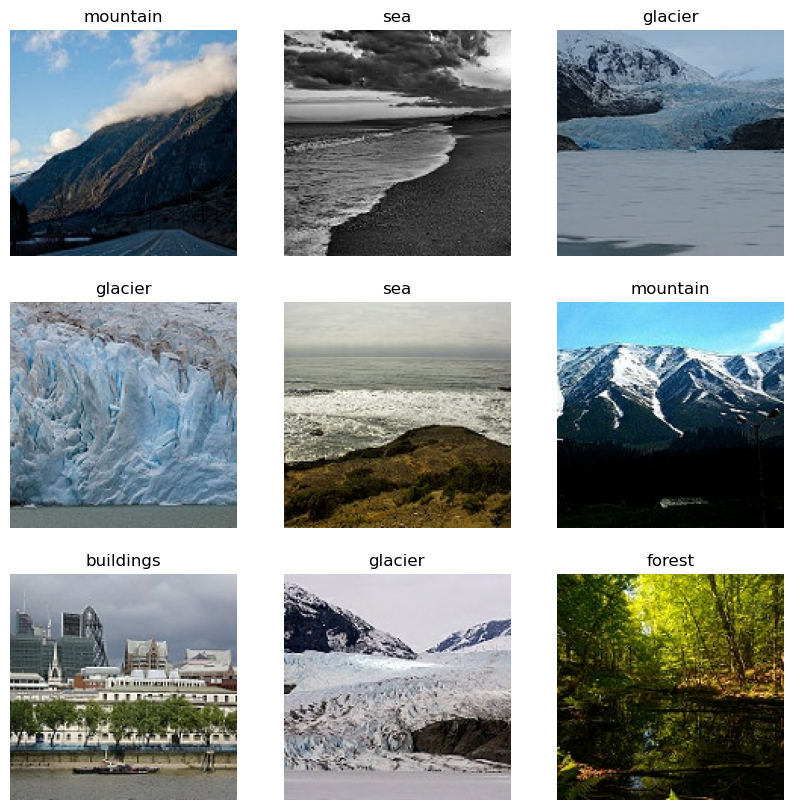

In [10]:
#eğitim veri setindeki ilk dokuz resim
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

In [11]:
# burada eğitime girecek bir tensörün boyutunu görebilmekteyiz. İlk satır 32 adet (batch size) 3 kanallı 150x150 boyutunda
# resimden oluştuğunu, ikinci satır bu resimlere karşılık gelen sınıf numaralarının adetini veriyor.
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 150, 150, 3)
(32,)


# 3. Görsellerin eğitim için hazırlanması

In [12]:
# resimlerdeki piksel değerleri 0 ile 255 değerleri arasındadır. Bu değerleri eğitmek için uygun değildir. Uygun hale getirmek
# için verilerimizi standartlaşma işlemine tabi tutuyoruz. İşlem sonrasında değerlerin 0 ile 1 arasında olduğunu kontrolünü
# yapıyoruz
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
# işlem gören veri paketinden sonra gelecek olan veri paketini ön belleğe alır, böylece modelimizin daha hızlı çalışmasını
# sağlarız.
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 4. Evrişim Modelinin Oluşturulması

In [14]:
# modelimiz 5 evrişim katmanından oluşuyor. 1. katmanda 64 kanal, 2. ve 3. katmanda 32 kanal ve 4. ve 5. katmanda 16 kanal
# bulunmakatadır. filtre olarak her katmanda 3x3 luk filtre kullanıldı. Stride default olarak (1) seçildi ve padding uygulanmadı
# aktivasyon fonkiyonu olarak relu seçildi. son gizli katmanda ise 6 adet sınıf olduğu için 6 nöron eklendi.
num_classes = 6

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),    
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [15]:
# derlemede, optimizer olarak adam, loss fonksiyonu olarak verimiz 6 sınıf olduğundan Categorical Crossentropy ve başarı 
# ölçüm metriği olarak accuracy seçildi.
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# 5. Modelin Eğitim Aşaması

In [16]:
history=model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=11
    )

Epoch 1/11
439/439 [==============================] - 183s 413ms/step - loss: 1.1946 - accuracy: 0.5099 - val_loss: 1.0382 - val_accuracy: 0.5603
Epoch 2/11
439/439 [==============================] - 175s 398ms/step - loss: 0.9262 - accuracy: 0.6265 - val_loss: 0.8623 - val_accuracy: 0.6530
Epoch 3/11
439/439 [==============================] - 177s 403ms/step - loss: 0.7646 - accuracy: 0.7091 - val_loss: 0.6853 - val_accuracy: 0.7407
Epoch 4/11
439/439 [==============================] - 168s 383ms/step - loss: 0.6797 - accuracy: 0.7487 - val_loss: 0.6835 - val_accuracy: 0.7297
Epoch 5/11
439/439 [==============================] - 164s 373ms/step - loss: 0.6201 - accuracy: 0.7739 - val_loss: 0.5789 - val_accuracy: 0.7883
Epoch 6/11
439/439 [==============================] - 166s 377ms/step - loss: 0.5723 - accuracy: 0.7892 - val_loss: 0.5925 - val_accuracy: 0.7780
Epoch 7/11
439/439 [==============================] - 164s 374ms/step - loss: 0.5376 - accuracy: 0.8033 - val_loss: 0.5730 -

# 6. Model Özeti ve Değerlendirilmesi

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9

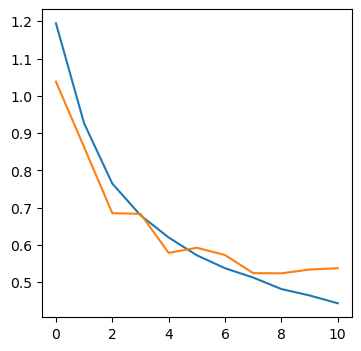

In [18]:
model_loss=history.history
loss=model_loss["loss"]
val_loss=model_loss["val_loss"]
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(loss,label="loss",color='tab:blue')
ax.plot(val_loss,label="val_loss",color='tab:orange')

In [19]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print('\nTest accuracy:', test_acc)

94/94 - 8s - loss: 0.5377 - accuracy: 0.8040 - 8s/epoch - 86ms/step

Test accuracy: 0.8040000200271606


In [20]:
# Sonuç

# Loss ve val_loss değerlerine ve grafiğe baktığımızda 9. epoch'dan sonra modelimiz aşırı öğrenmeye (overfitting) girdiğini 
# görüyoruz. Bu da bizi 9 epoch dan sonra eğitime devam etmenin gerek olmadığını gösteriyor.
# Test accuracy %0.80 olarak hesaplanmıştır. 

# Daha önceki hesaplamalarda 1. ve 2. katmanda 16 kanal, 3. ve 4. katmanda 32 kanal ve 5. katmanda 64 kanal yapıldığında
# veya tüm katmanlar 32 kanal yapıldığında 3. epoch dan sonra aşırı öğrenmeye girdiğini (overfitting) ve accuracy 
# değerinin %0.65-0.75 aralığında olduğu gözlenmiştir.

# Daha iyi bir sonuç için verilerde filtreleme işlemleri yapılabilir, shuffle gibi işlemler uygulanabilir veya dropout katmanı
# eklenebilir.

# 8. Test Görselleri ile Birkaç Görselin Tahmin Edilmesi

In [21]:
def plot_image(i, predictions_array, true_label, img):
    true_label = true_label[i]
    img=img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.numpy().astype("uint8"))

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(6))
    plt.yticks([])
    thisplot = plt.bar(range(6), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [22]:
probability_model = tf.keras.Sequential([model,tf.keras.layers.Softmax()])

94/94 [==============================] - 9s 89ms/step
Sınıf Adları: 0=buildings, 1=forest, 2=glacier, 3=mountain, 4=sea, 5=street


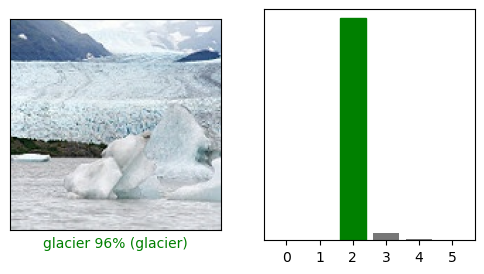

In [23]:
predictions = probability_model.predict(test_ds)
image_batch, label_batch = next(iter(test_ds))
print(f"Sınıf Adları: 0={class_names[0]}, 1={class_names[1]}, 2={class_names[2]}, 3={class_names[3]}, 4={class_names[4]}, 5={class_names[5]}")
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], label_batch, image_batch)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  label_batch)
plt.show()

94/94 [==============================] - 8s 87ms/step
Sınıf Adları: 0=buildings, 1=forest, 2=glacier, 3=mountain, 4=sea, 5=street


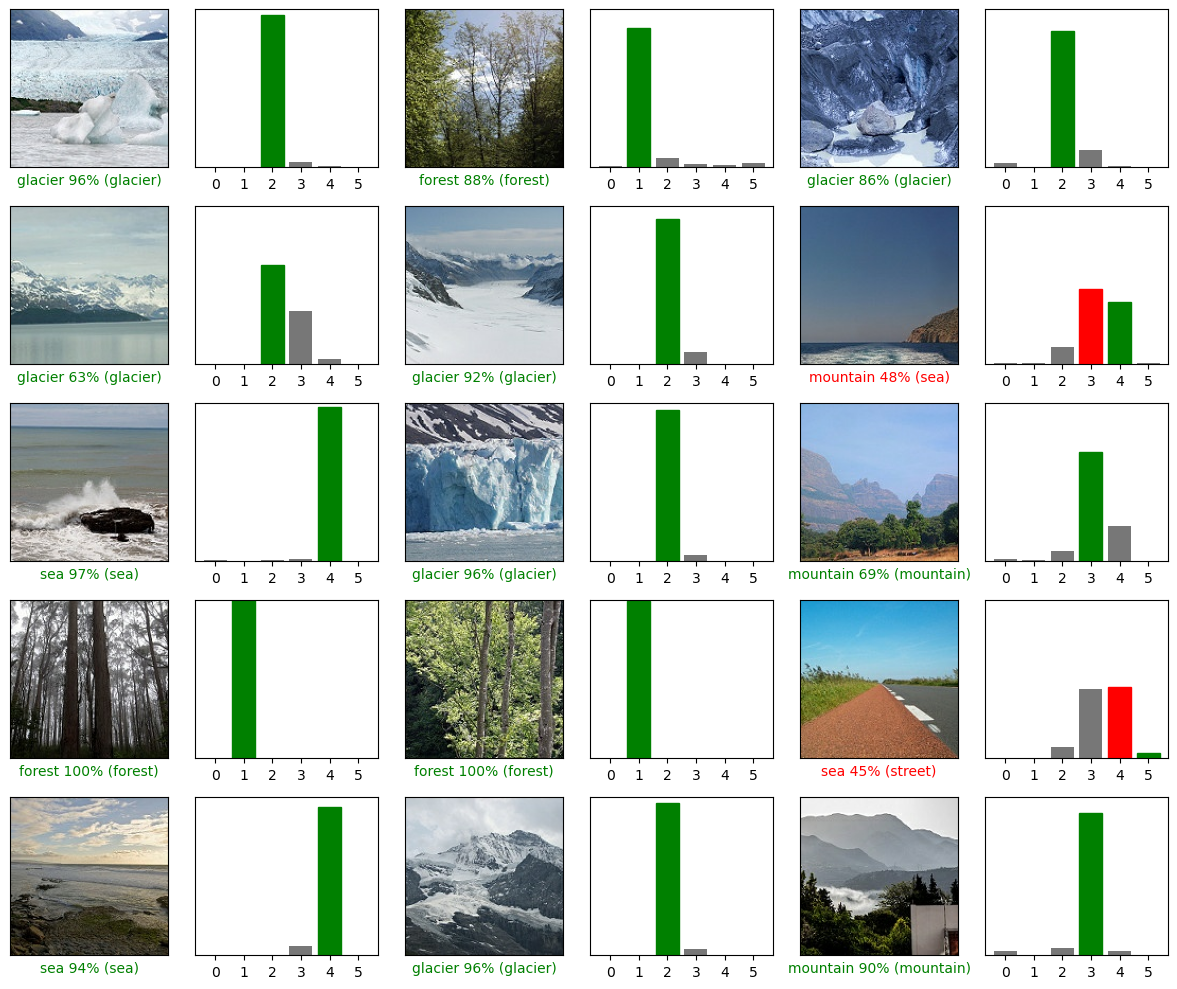

In [24]:
predictions = probability_model.predict(test_ds)
image_batch, label_batch = next(iter(test_ds))
print(f"Sınıf Adları: 0={class_names[0]}, 1={class_names[1]}, 2={class_names[2]}, 3={class_names[3]}, 4={class_names[4]}, 5={class_names[5]}")
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], label_batch, image_batch)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], label_batch)
plt.tight_layout()
plt.show()